Healthcare is one of the most critical sectors in the economy, and understanding the factors 
that drive 
insurance costs is essential for both insurers and patients.

This dataset provides a granular look at the personal health data of 1,338 individuals in 
the United States. It reveals how factors like age, BMI, smoking habits, and family size 
influence the final medical bills charged by health insurance companies.

### Importing the relevant libraries

In [152]:
# import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sms
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans

sns.set_theme()


# Download latest version
# path = kagglehub.dataset_download("hetmengar/medical-insurance-cost-prediction")
# print("Path to dataset files:", path)

### Loading the data

In [153]:
raw_data = pd.read_csv('medical-charges.csv')


#data.shape

### Copying the data into a new variable

In [154]:
data = raw_data.copy()
data.head(5)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### Dealing with dummy variables

sex, smoker, region

In [155]:
data['sex'].unique()


array(['female', 'male'], dtype=object)

In [156]:
data['smoker'].unique()

array(['yes', 'no'], dtype=object)

In [157]:
data['region'].unique()

array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)

### Mapping the data 

In [158]:
data['sex'] = data['sex'].map({'female': 0, 'male': 1})
data['smoker'] = data['smoker'].map({'yes': 1, 'no': 0})
data['region'] = data['region'].map({})

In [159]:
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,NaN,16884.92400
1,18,1,33.770,1,0,NaN,1725.55230
2,28,1,33.000,3,0,NaN,4449.46200
3,33,1,22.705,0,0,NaN,21984.47061
4,32,1,28.880,0,0,NaN,3866.85520


In [160]:
data.describe()

,age,sex,bmi,children,smoker,region,charges
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,0.0,1338.000000
mean,39.207025,0.505232,30.663397,1.094918,0.204783,NaN,13270.422265
std,14.049960,0.500160,6.098187,1.205493,0.403694,NaN,12110.011237
min,18.000000,0.000000,15.960000,0.000000,0.000000,NaN,1121.873900
25%,27.000000,0.000000,26.296250,0.000000,0.000000,NaN,4740.287150
50%,39.000000,1.000000,30.400000,1.000000,0.000000,NaN,9382.033000
75%,51.000000,1.000000,34.693750,2.000000,0.000000,NaN,16639.912515
max,64.000000,1.000000,53.130000,5.000000,1.000000,NaN,63770.428010


### Creating the regression

Declaring the dependent and independent variables

In [161]:
y = data['charges']
x = data[['age', 'sex', 'bmi', 'children', 'smoker']]



### Scale the inputs

In [162]:
from sklearn.preprocessing import StandardScaler

### Regression

In [163]:
reg = LinearRegression()
scaler = StandardScaler()
scaler.fit(x)
x_scaler = scaler.transform(x)
reg.fit(x_scaler, y)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


Find the intercept

In [164]:
reg.intercept_.round(3)

np.float64(13270.422)

Find the coefficients

In [165]:
reg.coef_.round(3)

array([3619.813,  -64.316, 1965.102,  571.685, 9613.767])

### Calculating the R-squared

In [166]:
reg.score(x_scaler, y)

0.7497225098709179

### Formulating the Adjusted R-squared

In [167]:
r2 = reg.score(x_scaler, y)
n = x.shape[0]
p = x.shape[1]

In [168]:
def adj_r2(r2, n, p):
    adj_r2 = 1 - (1 - r2) * (n - 1)/(n - p - 1)
    return adj_r2

In [169]:
adj_r2(r2, n, p)

0.7487830298028658

### Feature selection

In [170]:
from sklearn.feature_selection import f_regression


In [171]:
f_regression(x_scaler, y)


(array([ 131.17401258,    4.3997017 ,   54.70930805,    6.20603705,
        2177.61486806]),
 array([4.88669333e-029, 3.61327210e-002, 2.45908554e-013, 1.28521285e-002,
        8.27143584e-283]))

In [172]:
p_values = f_regression(x_scaler, y)[1]
p_values.round(3)



array([0.   , 0.036, 0.   , 0.013, 0.   ])

In [173]:
p_values
p_values_with_nan = [np.nan] + p_values
p_values


array([4.88669333e-029, 3.61327210e-002, 2.45908554e-013, 1.28521285e-002,
       8.27143584e-283])

### Creating a summary table

In [174]:
reg_summary = pd.DataFrame(data = x.columns.values, columns=["Features"])
reg_summary['Weights'] = reg.coef_[0], reg.coef_[1], reg.coef_[2], reg.coef_[3], reg.coef_[4]
reg_summary['P_values'] = p_values.round(3) 
reg_summary


,Features,Weights,P_values
0,age,3619.812911,0.000
1,sex,-64.316406,0.036
2,bmi,1965.102478,0.000
3,children,571.685407,0.013
4,smoker,9613.766915,0.000


In [175]:
reg_summary["Coeficients"] = reg.coef_.round(3)
reg_summary['p_values'] = p_values.round(3)
reg_summary

,Features,Weights,P_values,Coeficients,p_values
0,age,3619.812911,0.000,3619.813,0.000
1,sex,-64.316406,0.036,-64.316,0.036
2,bmi,1965.102478,0.000,1965.102,0.000
3,children,571.685407,0.013,571.685,0.013
4,smoker,9613.766915,0.000,9613.767,0.000


### Plotting the data

## Aligned by ChatGPT

sex_mean = data['sex'].mean()
bmi_mean = data['bmi'].mean()
children_mean = data['children'].mean()



age_sorted = np.sort(data['age'])

for smoker_value, label in [(0, "Non-smoker"), (1, "Smoker")]:
    plot_df = pd.DataFrame({
        'age': age_sorted,
        'sex': sex_mean,
        'bmi': bmi_mean,
        'children': children_mean,
        'smoker': smoker_value
    })

    plot_scaled = scaler.transform(plot_df)
    yhat = reg.predict(plot_scaled)

plt.plot(age_sorted, yhat, lw=3, label=label)

plt.scatter(data['age'], yhat, alpha=0.3) 
plt.xlabel("Age") 
plt.ylabel("Charges") 
plt.title("Predicted Insurance Charges vs Age") 
plt.legend() 
plt.show()


### Predictions

In [176]:
 # The values order: age, sex, bmi, children, smoke
#pred = pd.DataFrame([[19, 0, 27.9, 0, 1]], columns = x.columns)
pred_ = pd.DataFrame([[26, 1, 25, 0, 0]], columns = x.columns)
pred_scaled = scaler.transform(pred_)


In [177]:
reg.predict(pred_scaled).round(2)

array([2579.11])

## Clustering and mapping the data

In [178]:
data_mapped_cluster = raw_data.copy()
data_mapped_cluster


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [179]:
data_mapped_cluster['region'].unique()

array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)

In [180]:
data_mapped_cluster['sex'] = data_mapped_cluster['sex'].map({'female': 0, 'male': 1})
data_mapped_cluster['smoker'] = data_mapped_cluster['smoker'].map({'yes': 1, 'no': 0})
data_mapped_cluster['region'] = data_mapped_cluster['region'].map({'southwest': 1, 'southeast': 2, 'northwest': 3, 'northeast': 4})

In [190]:
x = data_mapped_cluster.iloc[:,1:7]
x

,sex,bmi,children,smoker,region,charges
0,0,27.900,0,1,1,16884.92400
1,1,33.770,1,0,2,1725.55230
2,1,33.000,3,0,2,4449.46200
3,1,22.705,0,0,3,21984.47061
4,1,28.880,0,0,3,3866.85520
...,...,...,...,...,...,...
1333,1,30.970,3,0,3,10600.54830
1334,0,31.920,0,0,4,2205.98080
1335,0,36.850,0,0,2,1629.83350
1336,0,25.800,0,0,1,2007.94500


In [197]:
kmeans = KMeans(4)

In [198]:
kmeans.fit(x)

c:\Users\assis\anaconda3\envs\py3-TF2.0\Lib\site-packages\sklearn\cluster\_kmeans.py:1425: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


,"n_clusters n_clusters: int, default=8The number of clusters to form as well as the number ofcentroids to generate.For an example of how to choose an optimal value for `n_clusters` refer to:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_silhouette_analysis.py`.",4
,"init init: {'k-means++', 'random'}, callable or array-like of shape (n_clusters, n_features), default='k-means++'Method for initialization:* 'k-means++' : selects initial cluster centroids using sampling based on an empirical probability distribution of the points' contribution to the overall inertia. This technique speeds up convergence. The algorithm implemented is ""greedy k-means++"". It differs from the vanilla k-means++ by making several trials at each sampling step and choosing the best centroid among them.* 'random': choose `n_clusters` observations (rows) at random from data for the initial centroids.* If an array is passed, it should be of shape (n_clusters, n_features) and gives the initial centers.* If a callable is passed, it should take arguments X, n_clusters and a random state and return an initialization.For an example of how to use the different `init` strategies, see:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_digits.py`.For an evaluation of the impact of initialization, see the example:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_stability_low_dim_dense.py`.",'k-means++'
,"n_init n_init: 'auto' or int, default='auto'Number of times the k-means algorithm is run with different centroidseeds. The final results is the best output of `n_init` consecutive runsin terms of inertia. Several runs are recommended for sparsehigh-dimensional problems (see :ref:`kmeans_sparse_high_dim`).When `n_init='auto'`, the number of runs depends on the value of init:10 if using `init='random'` or `init` is a callable;1 if using `init='k-means++'` or `init` is an array-like... versionadded:: 1.2 Added 'auto' option for `n_init`... versionchanged:: 1.4 Default value for `n_init` changed to `'auto'`.",'auto'
,"max_iter max_iter: int, default=300Maximum number of iterations of the k-means algorithm for asingle run.",300
,"tol tol: float, default=1e-4Relative tolerance with regards to Frobenius norm of the differencein the cluster centers of two consecutive iterations to declareconvergence.",0.0001
,"verbose verbose: int, default=0Verbosity mode.",0
,"random_state random_state: int, RandomState instance or None, default=NoneDetermines random number generation for centroid initialization. Usean int to make the randomness deterministic.See :term:`Glossary `.",None
,"copy_x copy_x: bool, default=TrueWhen pre-computing distances it is more numerically accurate to centerthe data first. If copy_x is True (default), then the original data isnot modified. If False, the original data is modified, and put backbefore the function returns, but small numerical differences may beintroduced by subtracting and then adding the data mean. Note that ifthe original data is not C-contiguous, a copy will be made even ifcopy_x is False. If the original data is sparse, but not in CSR format,a copy will be made even if copy_x is False.",True
,"algorithm algorithm: {""lloyd"", ""elkan""}, default=""lloyd""K-means algorithm to use. The classical EM-style algorithm is `""lloyd""`.The `""elkan""` variation can be more efficient on some datasets withwell-defined clusters, by using the triangle inequality. However it'smore memory intensive due to the allocation of an extra array of shape`(n_samples, n_clusters)`... versionchanged:: 0.18 Added Elkan algorithm.. versionchanged:: 1.1 Renamed ""full"" to ""lloyd"", and deprecated ""auto"" and ""full"". Changed ""auto"" to use ""lloyd"" instead of ""elkan"".",'lloyd'


### Clustering results

In [199]:
identified_clusters = kmeans.fit_predict(x)
identified_clusters

c:\Users\assis\anaconda3\envs\py3-TF2.0\Lib\site-packages\sklearn\cluster\_kmeans.py:1425: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


array([2, 0, 0, ..., 0, 0, 3], dtype=int32)

In [200]:
data_with_cluster = data_mapped_cluster.copy()
data_with_cluster['Clusters'] = identified_clusters
data_with_cluster

,age,sex,bmi,children,smoker,region,charges,Clusters
0,19,0,27.900,0,1,1,16884.92400,2
1,18,1,33.770,1,0,2,1725.55230,0
2,28,1,33.000,3,0,2,4449.46200,0
3,33,1,22.705,0,0,3,21984.47061,3
4,32,1,28.880,0,0,3,3866.85520,0
...,...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,3,10600.54830,2
1334,18,0,31.920,0,0,4,2205.98080,0
1335,18,0,36.850,0,0,2,1629.83350,0
1336,21,0,25.800,0,0,1,2007.94500,0


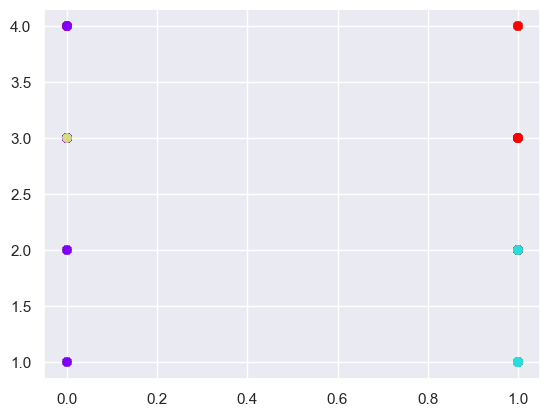

In [202]:
plt.scatter(data_with_cluster['smoker'], data_with_cluster['region'], c = data_with_cluster['Clusters'], cmap='rainbow')

plt.show()